# Two‑Field Reaction–Advection–Diffusion at the Edge of Chaos

This single cell simulates the coupled system:
$$\begin{aligned}
m_t &= \alpha_m(a-m),\\[2mm]
a_t &= \alpha_1(ma-a^3)+\alpha_2(m-a)\;\;\underbrace{-\,\alpha_k\,a\,m\,a_x}_{\text{non‑conservative advection}}\;+\;D\,a_{xx}.
\end{aligned}$$

**Critical (edge‑of‑chaos) recipes:**

- **Recipe A (balanced, intricate transport)**:  
  $\alpha_m{=}1.0,\;\alpha_1{=}1.0,\;\alpha_2{=}-0.98,\;D{=}0.01,\;\alpha_k{=}0.8$  
- **Recipe B (sharper, more convective)**:  
  $\alpha_m{=}1.0,\;\alpha_1{=}1.5,\;\alpha_2{=}-1.02,\;D{=}0.005,\;\alpha_k{=}0.33$

Time is integrated with RK4 and **uniform output frames**; periodic BCs; advection is handled by a conservative split plus a source correction so we can use a **Rusanov flux** robustly while keeping the *same* PDE semantics.

The plot shows a **space–time image** with time downward (y axis), x on the horizontal axis.


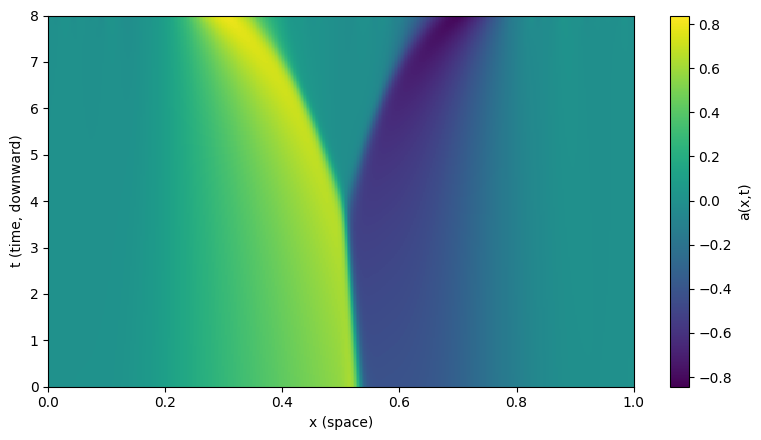

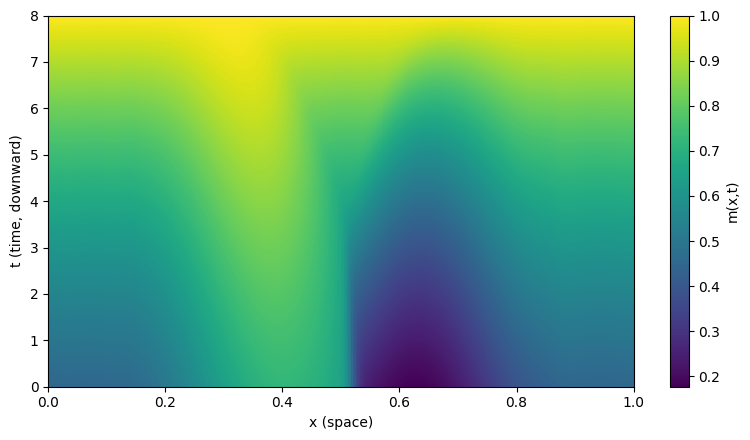

In [22]:
# Edge‑of‑chaos two‑field RAD (m,a) — single notebook cell
# m_t = alpha_m * (a - m)
# a_t = alpha1*(m*a - a**3) + alpha2*(m - a)  - alpha_k * a * m * a_x  + D * a_xx
# Advection handled via conservative split: -alpha_k a m a_x = -d_x( (alpha_k/2) a^2 m ) + (alpha_k/2) a^2 m_x
# Use Rusanov (LLF) for the flux divergence and centered diff for the source correction.
# Periodic BCs, RK4 in time, adaptive dt with uniform output sampling.

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------- Config ---------------------------------
L        = 1.0          # domain length
nx       = 400          # spatial cells
T_final  = 8.0          # total time
n_frames = 800          # number of stored frames
CFL      = 0.4

# Choose critical parameter recipe: 'A' or 'B'
critical_recipe = 'A'

if critical_recipe.upper() == 'A':
    alpha_m = 0.1
    alpha1  = 0.2
    alpha2  = 0   # slightly subcritical (long waves slightly damped)
    D       = 0.0001
    alpha_k = 0.1     # respects worst‑case |a*m|<=1 with ~5 cells per shock
elif critical_recipe.upper() == 'B':
    alpha_m = 1.0
    alpha1  = 1.5
    alpha2  = -1.02   # slightly supercritical to seed structure
    D       = 0.005
    alpha_k = 0.33
else:
    raise ValueError("critical_recipe must be 'A' or 'B'")

# ------------------------ Discretization ------------------------------
x  = np.linspace(0.0, L, nx, endpoint=False)
dx = L / nx

def reaction(a, m):
    return alpha1*(m*a - 2*a**3) + alpha2*(m - a)

def laplacian(u):
    return (np.roll(u, -1) - 2.0*u + np.roll(u, 1)) / (dx*dx)

def grad_center(u):
    return (np.roll(u, -1) - np.roll(u, 1)) / (2.0*dx)

def advective_divergence_rusanov_with_source(a, m):
    """Compute -∂x F + (alpha_k/2) a^2 m_x using
       H_{i+1/2} = 1/2(F_i + F_{i+1}) - 1/2 * amax_{i+1/2} * (a_{i+1}-a_i),
       where F = 0.5 * alpha_k * a^2 * m and amax = max(|∂F/∂a|_L, |∂F/∂a|_R) = max(|alpha_k*a*m|).
    """
    # Flux values at cell centers
    F  = 0.5 * alpha_k * (a*a) * m
    Fp = np.roll(F, -1)

    # Local characteristic speeds at L/R of interface
    sL = alpha_k * a * m
    sR = np.roll(sL, -1)
    amax = np.maximum(np.abs(sL), np.abs(sR))

    # Rusanov flux at interfaces i+1/2
    H = 0.5*(F + Fp) - 0.5*amax*(np.roll(a, -1) - a)
    Hm = np.roll(H, 1)
    div_flux = - (H - Hm) / dx

    # Source correction term from conservative split
    src = 0.5 * alpha_k * (a*a) * grad_center(m)
    return div_flux #+ src

def rhs(a, m):
    # a_t and m_t
    a_t = reaction(a, m) + advective_divergence_rusanov_with_source(a, m) + D * laplacian(a)
    m_t = alpha_m * (a - m)
    return a_t, m_t

def stable_dt(a, m):
    bounds = []
    # Advection bound
    vmax = np.max(np.abs(alpha_k * a * m))
    if vmax > 1e-14:
        bounds.append(dx / vmax)
    # Diffusion bound for 'a'
    if D > 0.0:
        bounds.append(dx*dx / (2.0 * D))
    # Reaction bounds (rough, but safe):
    # local partials
    r_a = alpha1*(m - 3*a*a) - alpha2
    r_m = alpha1*a + alpha2
    Lr  = np.max(np.abs(r_a) + np.abs(r_m))
    if Lr > 1e-14:
        bounds.append(1.0 / Lr)
    # memory ODE bound
    if alpha_m > 0:
        bounds.append(1.0 / alpha_m)
    if not bounds:
        return 0.01 * T_final
    return CFL * min(bounds)

def rk4_step(a, m, dt):
    a1, m1 = rhs(a, m)
    a2, m2 = rhs(a + 0.5*dt*a1, m + 0.5*dt*m1)
    a3, m3 = rhs(a + 0.5*dt*a2, m + 0.5*dt*m2)
    a4, m4 = rhs(a + dt*a3,     m + dt*m3)
    a_new = a + (dt/6.0)*(a1 + 2*a2 + 2*a3 + a4)
    m_new = m + (dt/6.0)*(m1 + 2*m2 + 2*m3 + m4)
    return a_new, m_new

# --------------------------- Initial data ----------------------------
rng = np.random.default_rng()
def init_fields(x):
    # Zero‑mean bimodal bumps plus small zero‑mean noise in [-1,1]
    def bump(xc, w, amp):
        return amp * np.exp(-((x - xc)**2) / (2*w*w))
    a0 = bump(0.3*L, 0.05*L, +0.8) + bump(0.7*L, 0.05*L, -0.8)
    a0 += 0.05 * (rng.random(x.shape) - 0.5) * 2.0
    a0 = np.clip(a0, -1.0, 1.0)
    # Start memory close to a, but not identical (to create lag dynamics)
    m0 = a0 + 0.05 * (rng.random(x.shape) - 0.5) * 2.0
    m0 = np.clip(m0, -1.0, 1.0)
    m0 = m0*0+1
    return a0, m0

a, m = init_fields(x)

# --------------------------- Integrate --------------------------------
ts = np.linspace(0.0, T_final, n_frames)
frames_a = np.zeros((n_frames, nx), dtype=np.float64)
frames_m = np.zeros((n_frames, nx), dtype=np.float64)
t = 0.0
frame_idx = 0
frames_a[frame_idx] = a.copy(); frames_m[frame_idx] = m.copy()
frame_idx += 1
t_target = ts[frame_idx] if frame_idx < n_frames else T_final

while t < T_final - 1e-14 and frame_idx < n_frames:
    dt = stable_dt(a, m)
    dt = min(dt, t_target - t)
    dt = max(dt, 1e-12)
    a, m = rk4_step(a, m, dt)
    # clip variables to [-1,1] softly if desired (comment to disable)
    a = np.clip(a, -1.0, 1.0)
    m = np.clip(m, -1.0, 1.0)
    t += dt
    if t >= t_target - 1e-14:
        frames_a[frame_idx] = a.copy(); frames_m[frame_idx] = m.copy()
        frame_idx += 1
        t_target = ts[frame_idx] if frame_idx < n_frames else T_final

# ---------------------------- Plots -----------------------------------
fig1, ax1 = plt.subplots(figsize=(8, 4.5))
extent = (0.0, L, 0.0, T_final)  # y from 0 (top) to T_final (bottom)
im1 = ax1.imshow(frames_a, aspect='auto', origin='upper', extent=extent, interpolation='nearest')
ax1.set_xlabel('x (space)'); ax1.set_ylabel('t (time, downward)');
cbar1 = plt.colorbar(im1, ax=ax1); cbar1.set_label('a(x,t)')
plt.tight_layout(); plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 4.5))
im2 = ax2.imshow(frames_m, aspect='auto', origin='upper', extent=extent, interpolation='nearest')
ax2.set_xlabel('x (space)'); ax2.set_ylabel('t (time, downward)');
cbar2 = plt.colorbar(im2, ax=ax2); cbar2.set_label('m(x,t)')
plt.tight_layout(); plt.show()


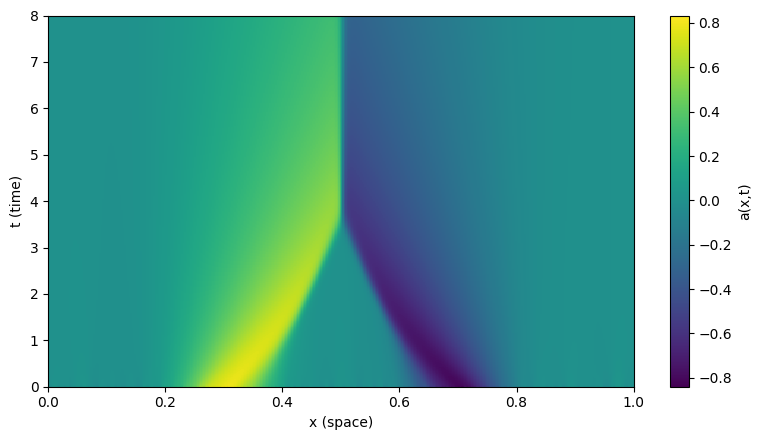

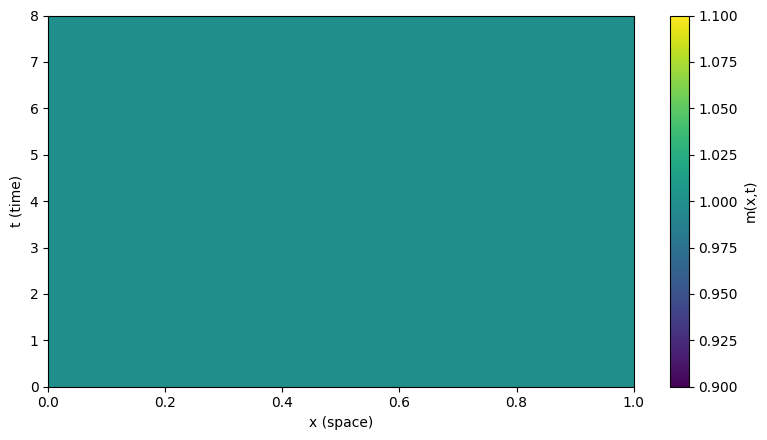

In [5]:
fig1, ax1 = plt.subplots(figsize=(8, 4.5))
extent = (0.0, L, 0.0, T_final)  # y from 0 (top) to T_final (bottom)
im1 = ax1.imshow(frames_a, aspect='auto', origin='lower', extent=extent, interpolation='nearest')
ax1.set_xlabel('x (space)'); ax1.set_ylabel('t (time)');
cbar1 = plt.colorbar(im1, ax=ax1); cbar1.set_label('a(x,t)')
plt.tight_layout(); plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 4.5))
im2 = ax2.imshow(frames_m, aspect='auto', origin='lower', extent=extent, interpolation='nearest')
ax2.set_xlabel('x (space)'); ax2.set_ylabel('t (time)');
cbar2 = plt.colorbar(im2, ax=ax2); cbar2.set_label('m(x,t)')
plt.tight_layout(); plt.show()